# Analiza Tour de France 2023

Analizirali bomo statistiko kolesarske dirke po Franciji iz leta 2023. Podatki so bili zajeti iz strani [Pro Cycling Stats](https://www.procyclingstats.com/race/tour-de-france/2023) in obdelani s pomočjo pythona.

## Uvod

*Tour de France* ali *Dirka po Franciji* je vsakoletna kolesarska cestna dirka, ki obstaja že od leta 1903, traja 3 tedne in pelje kolesarje, kot je očitno iz imena, večinoma po Francoskih pokrajinah.

V zadnjih letih sodeluje med 20 in 22 ekip *(ang. teams)*, vsaka sestavljena iz 8 kolesarjev.

Razdeljena je v 21 posameznih etap *(ang. stages)*, katerih točne poti se vsako leto spremenijo, vendar vedno seštejejo v pribljižno 3500 km.

Vsaka etapa ima svojega zmagovalca, ki jo je prekolesrail v najmanjšem času, končni zmagovalec dirke pa je tisti, katerega skupni čas vseh etap je najmanjši. Zmagovalno ekipo se določi glede na čase najhitrejših treh članov ekipe v vsaki etapi.

Zdaj, ko vemo osnove, moramo podatke uvoziti. 

In [118]:
import pandas as pd
from functools import reduce

%matplotlib inline

kolesarji = pd.read_csv('csv_datoteke/kolesarji.csv', index_col='id')
etape = pd.read_csv('csv_datoteke/podatki_o_etapah.csv', index_col='št')
rezultati_etap = []
for e in range(21):
    rezultati_etap.append(pd.read_csv(f'csv_datoteke/etapa{e}.csv', index_col='id'))

pd.options.display.max_rows = 10

Najprej si oglejmo naše kolesarje in njihove podatke:

In [119]:
kolesarji

,ime,država,tip,ekipa,starost,teža,višina,ODR,GC,TT,Sprint,Climber
id,,,,,,,,,,,,
19,Adam Yates,gb,Climber,UAE Team Emirates,30,58.0,1.73,1902.0,5792.0,1018.0,130.0,7037.0
161,Simon Yates,gb,Climber,Team Jayco AlUla,30,58.0,1.72,765.0,4835.0,1133.0,218.0,6186.0
11,Tadej Pogacar,si,Climber,UAE Team Emirates,24,66.0,1.76,3781.0,5194.0,1821.0,226.0,7108.0
37,Thibaut Pinot,fr,Climber,Groupama - FDJ,33,63.0,1.80,1915.0,6903.0,1544.0,170.0,8798.0
151,Michael Woods,ca,Climber,Israel - Premier Tech,36,64.0,1.75,2752.0,2206.0,40.0,186.0,4978.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,Jordi Meeus,be,Classic,BORA - hansgrohe,25,80.0,1.90,1220.0,76.0,30.0,1131.0,382.0
192,Cees Bol,nl,Sprint,Astana Qazaqstan Team,27,83.0,1.94,574.0,525.0,306.0,1291.0,460.0
64,Phil Bauhaus,de,Sprint,Bahrain - Victorious,28,71.0,1.84,750.0,225.0,1.0,2383.0,836.0


Id je številka ki jo ima kolesar na dresu ++++. Teža kolesarja je podana v kg in višina v m. Tip kolesarja pa predstavlja v kateri kategoriji je kolesar najboljši. Imamo več kategorij, saj je relief etape vsak dan malo drugačen, na par etapah pa se tudi način merjenja časa popolnoma spremeni, več o tem kasneje, zaenkrat je le pomembno da vemo da kolesarji nabirajo točke v kategorijah ODR (one day races ali enodnevne dirke), GC (general classification ali skupna razvrstitev), TT (time trial ali kronometer), Sprint (šprint) in Climber (hribolazec).

Kolesarji v vsaki kategoriji pridobijo točke, ko so na dirki, ki spada v to kategorijo (vsaka dirka lahko spada v več kategorij), dovolj visoko uvrščeni.

Oglejmo si torej podatke o naših etapah, da ugotovimo katere od kategorij so prisotne na Tour de France:

In [120]:
etape

,avg speed,dolžina,strmost,točke terena,višinci,won how
št,,,,,,
1,41.550,182.0,3,166,3221,0.35 km solo
2,43.726,208.9,2,141,2949,0.95 km solo
3,40.989,193.5,2,68,2667,Sprint of large group
4,41.090,181.8,1,20,1427,Sprint of large group
5,41.170,162.7,4,239,3652,20.2 km solo
...,...,...,...,...,...,...
17,34.386,165.7,4,445,5399,13.1 km solo
18,44.951,184.9,1,18,1216,Sprint of small group
19,49.130,172.8,2,50,1934,Sprint of 3 riders


Vidimo torej povprečno hitrost zmagovalca (avg speed) podano v km/h, dolžino etape v km, strmost na lestvici 1-5, ki je določena glede na teren in je na spletni strani [Pro Cycling Stats](https://www.procyclingstats.com/race/tour-de-france/2023) označena z ikono, točke terena, prekolesarjeni višinci v m in won how ali način zmage.
# Točke terena explain!!!

Na Tour de France kolesarji očitno ne nabirajo točk za ODR, saj je Tour de France 21-dnevna dirka, lahko pa nabirajo točke za ostale 4 kategorije, znotraj Tour de France pa so določene kategorije še posebaj izpostavljene in na koncu tudi zmagovalec v teh dobi nagrado, med dirko pa trenutni vodilni v določeni kategoriji nosi posebno majico. Tako ima najboljši na splošno rumeno majico, najboljši v šprintih zeleno, v vzpenanju belo z rdečimi pikami, najboljši med mladimi (pod 25) pa belo. V kategorije se bomo poglobili še kasneje.

Za zdaj si še oglejmo združene rezultate etap, vsi časi so podani v urah:

In [121]:
rezultati = reduce(lambda left,right: pd.merge(left, right, on = ['id'], how='outer'), rezultati_etap)
rezultati["skupni čas"] = rezultati.sum(axis='columns', min_count=21)

In [122]:
rezultati.sort_values('skupni čas')

,čas1,čas2,čas3,čas4,čas5,čas6,čas7,čas8,čas9,čas10,...,čas13,čas14,čas15,čas16,čas17,čas18,čas19,čas20,čas21,skupni čas
id,,,,,,,,,,,,,,,,,,,,,
1,4.38,4.78,4.72,4.42,3.96,3.91,3.77,4.21,4.47,3.92,...,3.31,3.98,4.78,0.54,4.85,4.11,3.75,3.46,2.94,82.21
11,4.38,4.78,4.72,4.42,3.98,3.91,3.77,4.21,4.47,3.92,...,3.31,3.98,4.78,0.57,4.95,4.11,3.75,3.46,2.94,82.36
19,4.38,4.78,4.72,4.42,3.98,3.96,3.77,4.21,4.49,3.92,...,3.31,3.98,4.79,0.60,4.88,4.11,3.75,3.46,2.94,82.40
27,4.38,4.78,4.72,4.42,3.98,3.95,3.77,4.21,4.48,3.92,...,3.31,3.98,4.79,0.60,4.90,4.11,3.75,3.47,2.94,82.41
161,4.38,4.78,4.72,4.42,3.98,3.95,3.77,4.22,4.48,3.92,...,3.31,4.04,4.82,0.59,4.83,4.11,3.75,3.46,2.94,82.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,4.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,4.73,5.11,4.72,4.42,4.41,4.44,3.77,4.23,4.81,4.30,...,3.71,4.60,5.27,0.72,NaN,NaN,NaN,NaN,NaN,NaN
191,4.74,5.11,4.72,4.42,4.52,4.51,3.77,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Osnovne povezave med podatki

skupni vzpon

V tabeli etape opazimo, da se zdijo strmost, točke terena in višinci sorazmerni, kar bi bilo logično, saj vsi rastejo z razgibanostjo terena. Pa še preverimo če to res drži:

<Axes: xlabel='strmost', ylabel='višinci'>

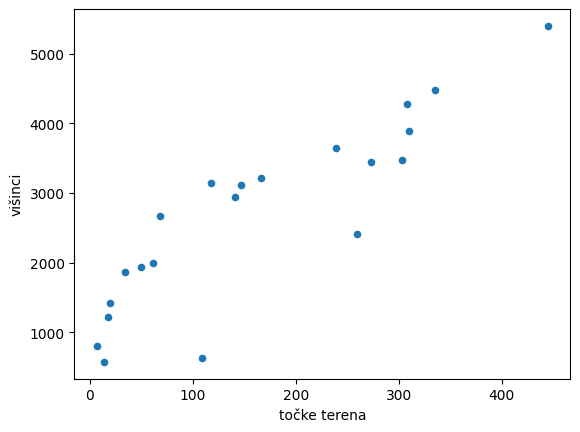

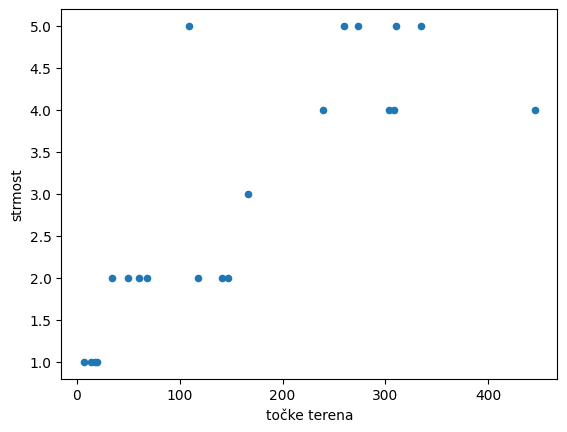

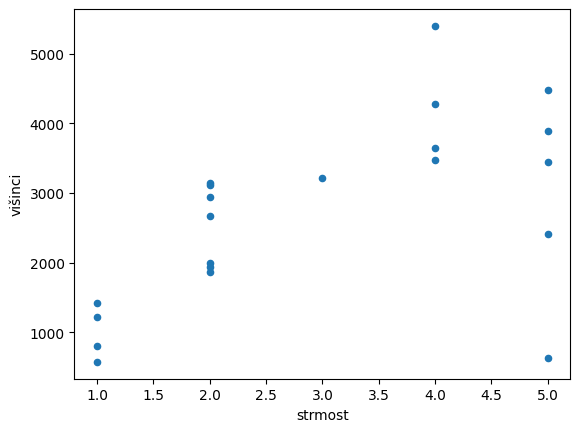

In [123]:
etape.plot.scatter(x='točke terena', y='višinci')
etape.plot.scatter(x='točke terena', y='strmost')
etape.plot.scatter(x='strmost', y='višinci')

Res izgleda da so vse tri sorazmerne, najlepše pa se to vidi na grafu med višinci in točkami terena. Torej lahko v prihodnje uprabljamo le eno od njih.

Ponavadi se v hrib kolesari precej počasneje kot po ravnini, torej pričakujemo, da bo to razvidno v razmerju med povprečno hitrostjo zmagovalca in višinci:

<Axes: xlabel='višinci', ylabel='avg speed'>

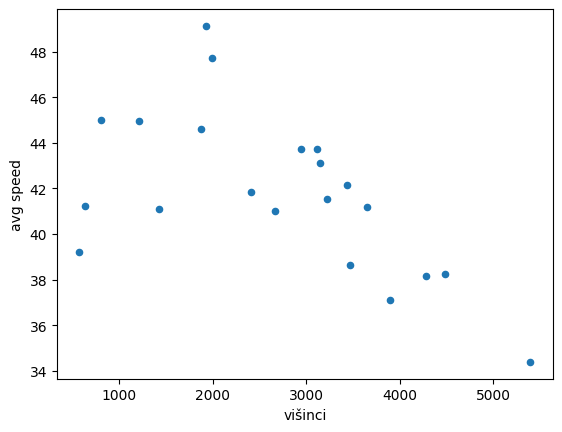

In [124]:
etape.plot.scatter(x='višinci', y='avg speed')

Res vidimo, da več kot je višincev manjša je povprečna hitrost. Malo izstopa pa ena točka na grafu levo spodaj, to je 21. etapa oziroma zadnji dan dirke. Glede na to, da je zadnji dan so kolesarji bolj utrujeni, obstaja pa še en razlog za odstopanje. Od leta 1975 naprej se 21. etapa odvija v Parizu in konča na Champs-Elysees. Profil Pariza je precej raven in kolesarjem ne dopušča veliko možnosti za napad *rumene majice*. Tako je po prvih parih letih brez napadov, zadnja etapa tradicionalno postala etapa na kateri kolesarji praznujejo konec dirke in uživajo s svojimi navijači ter se po nenapisanem dogovoru ne napadajo in posledično je njihova hitrost malo počasnejša.

## Fizične značilnosti kolesarjev

Zanima nas ali obstaja povezava med fizičnimi značilnostimi kolesarja in njegovim končnim rezultatom.

Najprej si oglejmo razmerje med skupnim časom in starostjo kolesarjev:

<Axes: xlabel='starost'>

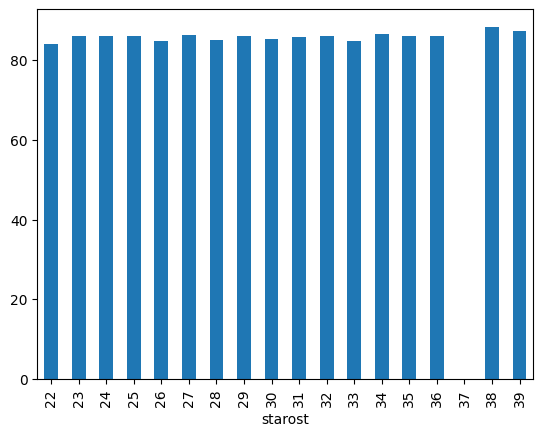

In [125]:
rezultati_starost = pd.merge(kolesarji, rezultati, left_on='id', right_on='id')
rezultati_starost.groupby('starost')['skupni čas'].mean().plot.bar()

Izgleda da starost ne vpliva na rezultate, vidimo pa, da noben od kolesarjev, ki so končali, ni star 37, zato bi bilo zanimivo pogledati koliko predstavnikov vsake starosti imamo.

ok primerjamo:

etape:

kolesarji:
rezultate kolesarjev posamezno glede na težo, višino, starost
povezava med tipom kolesarja in težo, višino, starost

ekipami rezultati
državami rezultati

tip kolesarja in tip etape rezultat
tip kolesarja država
tip kolesraja ekipa


